# Generate cellxgene

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

# Prepare INPUT

## Load raw and annoted andata

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [3]:
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')
adata = adata[[ 'female' in i for i in adata.obs.sex]]
adata.X.shape

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(243972, 28820)

In [4]:
adata_annotated = sc.read(path_to_gonads+'/FCA-gonads_female_annotated.h5ad')
adata_annotated.X.shape

(243972, 28266)

### Import lineage and somatic annotation

In [5]:
cell_annot = adata_annotated.obs['lineage'].to_dict()
adata.obs['lineage'] = adata.obs_names.map(cell_annot)
adata.obs['lineage'].value_counts()

Trying to set attribute `.obs` of view, copying.


Mesenchymal_GATA2    48660
preGranulosa         38881
Mesenchymal_LHX9     27616
Supporting           27498
lowQC                21802
CoelEpi              21411
Epithelial           16495
GermCells            10892
PV                   10338
Endothelial           8362
SMCs                  3044
Immune                2627
Neural                2264
Doublet               1841
cont                  1378
Erythroid              863
Name: lineage, dtype: int64

In [6]:
# Add somatic cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_somatic_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['lineageSomatic'] = adata.obs_names.map(cell_annot)
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].fillna(adata.obs['lineage'])
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].astype('category')
adata.obs['lineageSomatic'].value_counts()

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Mesenchymal_GATA2       48660
Oi                      24823
preGC_IIb               23803
lowQC                   21956
Epithelial              16495
preGC_I                 16364
preGC_IIa               13461
GermCells               10892
PV                      10338
Endothelial              8362
OSE                      8081
early_supporting         4509
CoelEpi_LHX9             4451
early_sPAX8              3717
CoelEpi_GATA2            3506
Gi                       3385
SMCs                     3044
cont                     2799
Immune                   2627
early_somatic            2420
Neural                   2264
Doublet                  1841
Sertoli                  1513
CoelEpi_LHX9_cycling     1467
Ti                       1185
Erythroid                 863
CoelEpi                   476
granulosa                 366
Supporting                103
FetalLeydig                80
late_sPAX8                 68
Mesenchymal_LHX9           48
preGranulosa                5
Name: line

## Remove lowQC cells and artifacts

In [7]:
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont', 'Mesenchymal_LHX9', 'Supporting', 'Sertoli', 'Ti', 'FetalLeydig', 'late_sPAX8', 'preGranulosa', 'CoelEpi'] for i in adata.obs.lineageSomatic]]

In [8]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()

Total number of cells: 213898
Total number of genes: 28820


,counts,freqs
categories,,
F81,8628,0.040337
F83,10557,0.049355
F84,2854,0.013343
F86,3301,0.015433
F87,2477,0.011580
F89,1485,0.006943
F91,4638,0.021683
F96,1760,0.008228
F99,6267,0.029299


## Import UMAP

In [9]:
adata_annotated = adata_annotated[[ i in adata.obs_names for i in adata_annotated.obs_names ]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
adata.obsm['X_umap'] = adata_annotated.obsm['X_umap']
adata.obsm['X_scVI'] = adata_annotated.obsm['X_scVI']
# adata.obsp['connectivities'] = adata_annotated.obsp['connectivities']
# adata.obsp['distances'] = adata_annotated.obsp['distances']
# adata.uns['celltype_colors'] = adata_annotated.uns['celltype_colors']
# adata.uns['neighbors'] = adata_annotated.uns['neighbors']

## Remove un necessary data

In [11]:
del adata_annotated

In [12]:
del adata.obs['study']
del adata.obs['stage']
del adata.obs['batch_collection']
del adata.obs['lineages_v1']
del adata.obs['celltype_v1']
del adata.obs['lineage_v2']
del adata.obs['somatic_celltype_v2']
del adata.obs['batch']

# Normalize data

In [13]:
adata.raw = adata.copy()

In [14]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)                                                                                                            
# sc.pp.scale(adata, max_value=10)

... storing 'lineage' as categorical


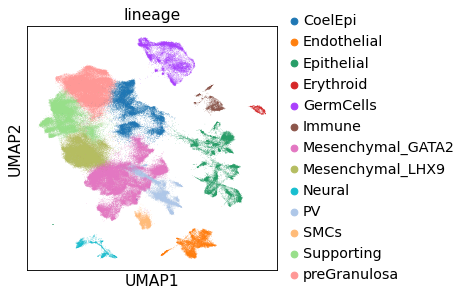

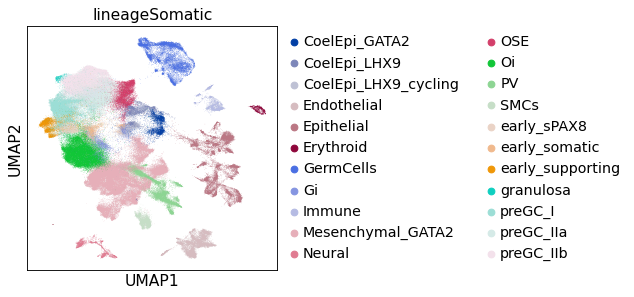

In [15]:
sc.pl.umap(adata, color='lineage')
sc.pl.umap(adata, color='lineageSomatic')

In [16]:
adata.write('/nfs/cellgeni/tickets/tic-613/human_main_female.h5ad')